<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Evaluating SVM on Multiple Datasets

_Authors: Kiefer Katovich (SF)_

---

In this lab you can explore several datasets with SVM classifiers compared to logistic regression and kNN classifiers. 

Your datasets folder has these four datasets to choose from for the lab:

**Breast cancer**

    ./datasets/breast_cancer_wisconsin

**Spambase**

    ./datasets/spam

**Car evaluation**

    ./datasets/car_evaluation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Load the breast cancer data

- Are there any missing values? Impute or clean if so.
- Select a classification target and predictors.

In [2]:
df = pd.read_csv('../datasets/breast_cancer_wisconsin/breast_cancer.csv', na_values='?')

In [3]:
df.head()

,Sample_code_number,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [4]:
df.shape

(699, 11)

In [5]:
df.isnull().sum()

Sample_code_number              0
Clump_Thickness                 0
Uniformity_of_Cell_Size         0
Uniformity_of_Cell_Shape        0
Marginal_Adhesion               0
Single_Epithelial_Cell_Size     0
Bare_Nuclei                    16
Bland_Chromatin                 0
Normal_Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

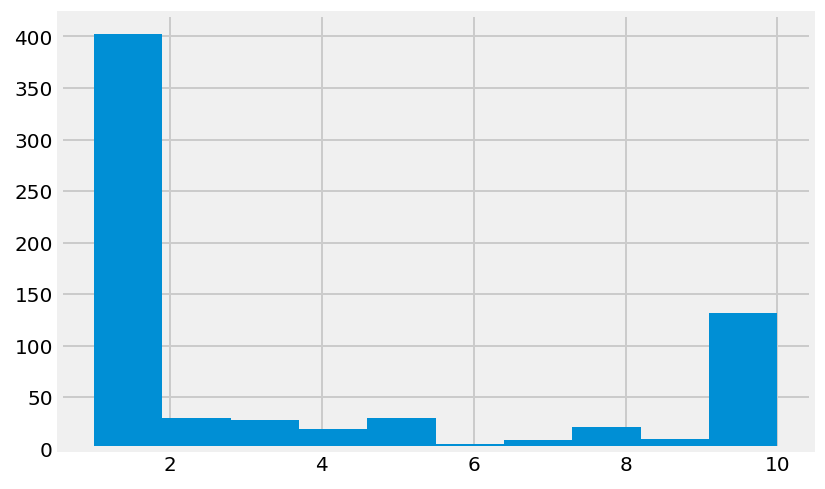

In [6]:
# 16 missing values in Bare_Nuclei
df['Bare_Nuclei'].hist()

In [7]:
# which class are the missing values?
df[df['Bare_Nuclei'].isnull()]['Class'].value_counts()

2    14
4     2
Name: Class, dtype: int64

In [8]:
# I'll drop them as 14 observations is small compared to the sample size
df.dropna(inplace=True)
df.isnull().sum()

Sample_code_number             0
Clump_Thickness                0
Uniformity_of_Cell_Size        0
Uniformity_of_Cell_Shape       0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [9]:
df['Class'].value_counts()

2    444
4    239
Name: Class, dtype: int64

In [10]:
X = df.drop(['Sample_code_number', 'Class'], axis = 1)
y = df['Class'].map(lambda x: 1 if x == 4 else 0)

In [11]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xn = ss.fit_transform(X)

### 2. Build an SVM classifier on the data

For details on the SVM classifier, see here:

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

- What's the baseline for the accuracy?
- Initialize and train a linear svm. What's the average accuracy score with a 5-fold cross validation?
- Repeat using a radial basis function (rbf) classifier. Compare the scores. Which one is better?
- Print a confusion matrix and classification report for your best model using training & testing data.

Classification report:

```python
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
```

Confusion matrix:

```python
df_confusion = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
```

In [12]:
#accuracy baseline => 65%
y.value_counts() / len(y)

0    0.650073
1    0.349927
Name: Class, dtype: float64

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(kernel=kernel, degree=3)
    scores = cross_val_score(svm, Xn, y, cv=5, scoring='roc_auc')
    sm = scores.mean()
    ss = scores.std()
    print("{} - Average score: {:0.3} +/- {:0.3}".format(kernel,sm, ss))

linear - Average score: 0.996 +/- 0.00369
poly - Average score: 0.996 +/- 0.00344
rbf - Average score: 0.989 +/- 0.0115
sigmoid - Average score: 0.987 +/- 0.00783


In [15]:
# cross val on linear kernel resulted in better scores however,
# scores were very very close in this instance
# we'll use the linear kernal to build/test our final model below.

In [16]:
from sklearn.metrics import classification_report

def print_cm_cr(y_true, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_true, 
                            y_pred, 
                            rownames=['Actual'], 
                            colnames=['Predicted'], 
                            margins=True)
    print(confusion)
    print('')
    print(classification_report(y_true, y_pred))
    

In [17]:
from sklearn.model_selection import train_test_split

lin_model = SVC(kernel='linear')
X_train, X_test, y_train, y_test = train_test_split(Xn, y, stratify=y, test_size=0.33)
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print_cm_cr(y_test, y_pred)

Predicted    0   1  All
Actual                 
0          140   7  147
1            4  75   79
All        144  82  226

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       147
          1       0.91      0.95      0.93        79

avg / total       0.95      0.95      0.95       226



#### 2.2 Are there more false positives or false negatives? Is this good or bad?

> Answer:
More false negatives is bad from the point of view of the patient and good from the point of view of the insurance company. Vice versa otherwise.

### 3. Perform the steps above with a different dataset.

Repeat each step.

In [18]:
car = pd.read_csv('../datasets/car_evaluation/car.csv')

In [19]:
car.shape

(1728, 7)

In [20]:
car.head(3)

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc


In [21]:
for c in car.columns:
    print(c, car[c].unique())

buying ['vhigh' 'high' 'med' 'low']
maint ['vhigh' 'high' 'med' 'low']
doors ['2' '3' '4' '5more']
persons ['2' '4' 'more']
lug_boot ['small' 'med' 'big']
safety ['low' 'med' 'high']
acceptability ['unacc' 'acc' 'vgood' 'good']


In [22]:
# any na?
car.isnull().sum()

buying           0
maint            0
doors            0
persons          0
lug_boot         0
safety           0
acceptability    0
dtype: int64

In [24]:
import patsy


y = car['acceptability'].map(lambda x: 1 if x in ['vgood','good'] else 0)

# NOTE: we're using all the dummy vaiables 
# because we removed the intercept with -1
X = patsy.dmatrix("~ buying + maint + doors + persons + lug_boot + safety -1",
                  data=car, return_type='dataframe')

ss = StandardScaler()
Xn = ss.fit_transform(X)

In [26]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(kernel=kernel, degree=3)
    scores = cross_val_score(svm, Xn, y, cv=5, scoring='roc_auc')
    sm = scores.mean()
    ss = scores.std()
    print("{} - Average score: {:0.3} +/- {:0.3}".format(kernel,sm, ss))

linear - Average score: 0.957 +/- 0.0543
poly - Average score: 0.931 +/- 0.0976
rbf - Average score: 0.922 +/- 0.11
sigmoid - Average score: 0.911 +/- 0.0987


In [27]:
# cross val on linear kernel resulted in better scores.  
# we'll use the linear kernal to build/test our final model below.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(Xn, y, stratify=y, test_size=0.33)
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print_cm_cr(y_test, y_pred)

Predicted    0   1  All
Actual                 
0          521   6  527
1            8  36   44
All        529  42  571

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       527
          1       0.86      0.82      0.84        44

avg / total       0.98      0.98      0.98       571



### 4. Compare SVM, kNN and logistic regression using a dataset.

You should:

- Gridsearch optimal parameters for both (for SVM, just gridsearch C and kernel).
- Cross-validate scores.
- Examine confusion matrices and classification reports.

**Bonus:**

Plot "learning curves" for the best models of each. This is a great way see how training/testing size affects the scores. Look at the documentation for how to use this function in sklearn.

http://scikit-learn.org/stable/modules/learning_curve.html#learning-curves

In [29]:
# ill use the car dataset to compare models
car.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [30]:
# linear kernal SVM
X_train, X_test, y_train, y_test = train_test_split(Xn, y, stratify=y, test_size=0.33)
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print_cm_cr(y_test, y_pred)

Predicted    0   1  All
Actual                 
0          526   1  527
1            7  37   44
All        533  38  571

             precision    recall  f1-score   support

          0       0.99      1.00      0.99       527
          1       0.97      0.84      0.90        44

avg / total       0.99      0.99      0.99       571



In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [32]:
models = {'knn':(KNeighborsClassifier(), {
                    'n_neighbors':range(1,51),
                    'weights':['distance','uniform']
                }),
          'svc':(SVC(),{
                            'C':np.logspace(-3, 4, 5),
                            'gamma':np.logspace(-5, 4, 5),
                            'kernel':['linear','rbf']
                        }),
          'lr':(LogisticRegression(), {
                        'penalty':['l1','l2'],
                        'C':np.logspace(-4, 4, 40),
                        'solver':['liblinear']
                    })
         }

In [33]:
# This can take a lot of time, especially for SVM

for name,(model,parameters) in models.items():
    print('----- {} -----'.format(name))
    gs = GridSearchCV(model, parameters, cv=5, 
                      verbose=0, n_jobs=-1, scoring='roc_auc')
    gs.fit(Xn, y)
    print(gs.best_params_)
    print(gs.best_score_)
    print('')

----- knn -----
{'n_neighbors': 32, 'weights': 'uniform'}
0.8269850899639418

----- svc -----
{'C': 10000.0, 'gamma': 0.0017782794100389228, 'kernel': 'rbf'}
0.983633697554515

----- lr -----
{'C': 3888.155180308085, 'penalty': 'l1', 'solver': 'liblinear'}
0.9802154719464474

